In [1]:
import tensorflow as tf
tf.test.is_gpu_available()
#tf.test.is_built_with_cuda()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import argparse
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from imutils import paths
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from model_mobile import get_model

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
DATA_DIR = 'C:/Users/212733771/Documents/Covid-Ultrasound/selected_frames/'
MODEL_DIR = 'C:/Users/212733771/Documents/Covid-Ultrasound/mobilenet_models'
FOLD = 0
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 16
TRAINABLE_BASE_LAYERS = 1
IMG_WIDTH, IMG_HEIGHT = (224,224)

In [4]:

model_name = 'pocus_fold_{0}'
plot_path = 'pocus_fold_{0}'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# # grab the list of images in our dataset directory, then initialize
# # the list of data (i.e., images) and class images
# print('Loading images...')
# imagePaths = list(paths.list_images(DATA_DIR))
# data = []
# labels = []

# print(f'Model is called : {model_name}')
# print(f'selected fold: {FOLD}')

# train_labels, test_labels = [], []
# train_data, test_data = [], []

In [5]:
train_val_test={}
label_dict = {'cov':'covid','reg':'regular','pneu':'pneumonia'}
for test_train_dir in os.listdir(DATA_DIR):
    #print(test_train_dir)
    save_image_dir_foldwide = os.path.join(DATA_DIR,test_train_dir)
    label_flod={}
    # label_flod.append(test_train_dir)
    for key,label_folder in label_dict.items():
        print(label_folder)
        fold_path = os.path.join(save_image_dir_foldwide,label_folder)
        print(len(os.listdir(fold_path)))
        # label_flod.append(os.listdir(fold_path))
        label_flod[key]=[os.path.join(fold_path, f) for f in os.listdir(fold_path)] #os.listdir(fold_path)
    train_val_test[test_train_dir] = label_flod

covid
165
regular
83
pneumonia
267
covid
187
regular
126
pneumonia
173
covid
404
regular
122
pneumonia
392
covid
458
regular
83
pneumonia
81
covid
177
regular
98
pneumonia
352


In [6]:
train_folders=['train_test_1','train_test_2','train_test_3']
val_folders=['train_test_4']
test_folders=['train_test_5']
train_path=[]
train_data=[]
train_labels=[]
val_path=[]
val_data=[]
val_labels=[]
test_path=[]
test_data=[]
test_labels=[]
for path_key,folder in train_val_test.items():
    print(path_key)
    for type_key,paths in folder.items():
        print(type_key)
        print(len(paths))
        if (path_key in train_folders):
           train_path+= paths
           for imagePath in paths:
                image_org = np.load(imagePath,allow_pickle=False)
                assert image_org.shape[0] == 3
                image=np.zeros(shape=(IMG_WIDTH, IMG_HEIGHT,image_org.shape[0])).astype(image_org.dtype)
                for i in range(len(image_org)):
                    # image[i] = cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB)  
                    image[:,:,i] = cv2.resize(cv2.cvtColor(image_org[i], cv2.COLOR_BGR2GRAY), (IMG_WIDTH, IMG_HEIGHT)) 
                train_labels.append(type_key)
                train_data.append(image)                      
        if (path_key in val_folders):
           val_path+= paths
           for imagePath in paths:
                image_org = np.load(imagePath,allow_pickle=False)
                assert image_org.shape[0] == 3
                image=np.zeros(shape=(IMG_WIDTH, IMG_HEIGHT,image_org.shape[0])).astype(image_org.dtype)
                for i in range(len(image_org)):
                    # image[i] = cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB)  
                    image[:,:,i] = cv2.resize(cv2.cvtColor(image_org[i], cv2.COLOR_BGR2GRAY), (IMG_WIDTH, IMG_HEIGHT)) 
                val_labels.append(type_key)
                val_data.append(image)             
        if (path_key in test_folders):
           test_path+= paths   
           for imagePath in paths:
                image_org = np.load(imagePath,allow_pickle=False)
                assert image_org.shape[0] == 3
                image=np.zeros(shape=(IMG_WIDTH, IMG_HEIGHT,image_org.shape[0])).astype(image_org.dtype)
                for i in range(len(image_org)):
                    # image[i] = cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB)  
                    image[:,:,i] = cv2.resize(cv2.cvtColor(image_org[i], cv2.COLOR_BGR2GRAY), (IMG_WIDTH, IMG_HEIGHT)) 
                test_labels.append(type_key)
                test_data.append(image)                     

print(
    '\nNumber of training samples: '+str(len(train_labels))+' \n'
    'Number of testing samples: '+str(len(test_labels))+''
)

train_data = np.array(train_data)
test_data = np.array(test_data)
val_data = np.array(val_data)

train_test_1
cov
165
reg
83
pneu
267
train_test_2
cov
187
reg
126
pneu
173
train_test_3
cov
404
reg
122
pneu
392
train_test_4
cov
458
reg
83
pneu
81
train_test_5
cov
177
reg
98
pneu
352

Number of training samples: 1919 
Number of testing samples: 627


In [26]:
# for imagePath in imagePaths:
#     path_parts = imagePath.split(os.path.sep)
#     # extract the split
#     train_test = path_parts[-3][-1]
#     # extract the class label from the filename
#     label = path_parts[-2]
#     # load the image, swap color channels, and resize it to be a fixed
#     # 224x224 pixels while ignoring aspect ratio
#     image = cv2.imread(imagePath)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

#     # update the data and labels lists, respectively
#     if train_test == str(FOLD+1):
#         test_labels.append(label)
#         test_data.append(image)
#     else:
#         train_labels.append(label)
#         train_data.append(image)



In [7]:
len(test_labels)

627

In [8]:

assert len(set(train_labels)) == len(set(test_labels)), (
    'Something went wrong. Some classes are only in train or test data.'
)  # yapf: disable

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
train_data = np.array(train_data) / 255.0
test_data = np.array(test_data) / 255.0
train_labels_text = np.array(train_labels)
test_labels_text = np.array(test_labels)

num_classes = len(set(train_labels))

# perform one-hot encoding on the labels
lb = LabelBinarizer()
lb.fit(train_labels_text)

train_labels = lb.transform(train_labels_text)
test_labels = lb.transform(test_labels_text)

In [9]:

if num_classes == 2:
    train_labels = to_categorical(train_labels, num_classes=num_classes)
    test_labels = to_categorical(test_labels, num_classes=num_classes)

trainX = train_data
trainY = train_labels
testX = test_data
testY = test_labels
print('Class mappings are:', lb.classes_)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Load the VGG16 network
model = get_model(
    input_size=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes=num_classes
)

Class mappings are: ['cov' 'pneu' 'reg']


In [10]:
num_layers = len(model.layers)
num_layers

776

In [11]:
from keras.metrics import Metric
# Number of layers in model head (fresh weights), this is fixed in get_model.
#num_head_layers =30
# Freeze all VGG layers apart from the last layers (TRAINABLE_BASE_LAYERS)
#num_layers = len(model.layers)
#for ind, layer in enumerate(model.layers):
#    if ind < num_layers - num_head_layers - TRAINABLE_BASE_LAYERS:
#        layer.trainable = False

# Define callbacks
earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

mcp_save = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'fold_' + str(FOLD) + '_epoch_{epoch:02d}'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=7,
    verbose=1,
    epsilon=1e-4,
    mode='min'
)
# To show balanced accuracy
# metrics = Metric((testX, testY), model)

# compile model
print('Compiling model...')
opt = Adam(lr=LR, decay=LR / EPOCHS)
model.compile(
    loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']
)

print('Model has {model.count_params()} parameters')
print('Model summary {model.summary()}')
model.summary()

Compiling model...
Model has {model.count_params()} parameters
Model summary {model.summary()}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             

c:\Users\212733771\AppData\Local\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 separable_conv_2_bn_reduction_  (None, 28, 28, 22)  88          ['separable_conv_2_reduction_righ
 right1_stem_2 (BatchNormalizat                                  t1_stem_2[0][0]']                
 ion)                                                                                             
                                                                                                  
 separable_conv_1_pad_reduction  (None, 61, 61, 22)  0           ['activation_16[0][0]']          
 _right2_stem_2 (ZeroPadding2D)                                                                   
                                                                                                  
 activation_18 (Activation)     (None, 56, 56, 22)   0           ['adjust_bn_stem_2[0][0]']       
                                                                                                  
 reduction

In [12]:

# train the head of the network
print('Starting training model...')
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

# make predictions on the testing set
print('Evaluating network...')
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print('classification report sklearn:')
print(
    classification_report(
        testY.argmax(axis=1), predIdxs, target_names=lb.classes_
    )
)


Starting training model...


C:\Users\212733771\AppData\Local\Temp\ipykernel_11464\3400543215.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.8035WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 39 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_accuracy improved from -inf to 0.40670, saving model to C:/Users/212733771/Documents/Covid-Ultrasound/mobilenet_models\fold_0_epoch_01


INFO:tensorflow:Assets written to: C:/Users/212733771/Documents/Covid-Ultrasound/mobilenet_models\fold_0_epoch_01\assets


INFO:tensorflow:Assets written to: C:/Users/212733771/Documents/Covid-Ultrasound/mobilenet_models\fold_0_epoch_01\assets


119/119 [==============================] - 269s 2s/step - loss: 0.4836 - accuracy: 0.8035 - val_loss: 1.4977 - val_accuracy: 0.4067 - lr: 1.0000e-04
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9679WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 118s 989ms/step - loss: 0.1124 - accuracy: 0.9679 - lr: 1.0000e-04
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9795WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 120s 1s/step - loss: 0.0620 - accuracy: 0.9795 - lr: 1.0000e-04
Epoch 4/50
119/119 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9916WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 118s 987ms/step - loss: 0.0361 - accuracy: 0.9916 - lr: 1.0000e-04
Epoch 5/50
119/119 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9937WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 121s 1s/step - loss: 0.0319 - accuracy: 0.9937 - lr: 1.0000e-04
Epoch 6/50
119/119 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9963WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 116s 973ms/step - loss: 0.0246 - accuracy: 0.9963 - lr: 1.0000e-04
Epoch 7/50
119/119 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9953WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 966ms/step - loss: 0.0231 - accuracy: 0.9953 - lr: 1.0000e-04
Epoch 8/50
119/119 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9937WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 966ms/step - loss: 0.0280 - accuracy: 0.9937 - lr: 1.0000e-04
Epoch 9/50
119/119 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9953WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 117s 984ms/step - loss: 0.0237 - accuracy: 0.9953 - lr: 1.0000e-04
Epoch 10/50
119/119 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9947WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 116s 975ms/step - loss: 0.0223 - accuracy: 0.9947 - lr: 1.0000e-04
Epoch 11/50
119/119 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9984WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 116s 970ms/step - loss: 0.0111 - accuracy: 0.9984 - lr: 1.0000e-04
Epoch 12/50
119/119 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9979WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 968ms/step - loss: 0.0148 - accuracy: 0.9979 - lr: 1.0000e-04
Epoch 13/50
119/119 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9974WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 116s 972ms/step - loss: 0.0125 - accuracy: 0.9974 - lr: 1.0000e-04
Epoch 14/50
119/119 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9968WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 118s 990ms/step - loss: 0.0119 - accuracy: 0.9968 - lr: 1.0000e-04
Epoch 15/50
119/119 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9989WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 121s 1s/step - loss: 0.0105 - accuracy: 0.9989 - lr: 1.0000e-04
Epoch 16/50
119/119 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9937WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 117s 978ms/step - loss: 0.0244 - accuracy: 0.9937 - lr: 1.0000e-04
Epoch 17/50
119/119 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9958WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 968ms/step - loss: 0.0174 - accuracy: 0.9958 - lr: 1.0000e-04
Epoch 18/50
119/119 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9974WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 116s 970ms/step - loss: 0.0140 - accuracy: 0.9974 - lr: 1.0000e-04
Epoch 19/50
119/119 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9989WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 968ms/step - loss: 0.0098 - accuracy: 0.9989 - lr: 1.0000e-04
Epoch 20/50
119/119 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9974WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 966ms/step - loss: 0.0089 - accuracy: 0.9974 - lr: 1.0000e-04
Epoch 21/50
119/119 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9963WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 968ms/step - loss: 0.0170 - accuracy: 0.9963 - lr: 1.0000e-04
Epoch 22/50
119/119 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9984WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 966ms/step - loss: 0.0083 - accuracy: 0.9984 - lr: 1.0000e-04
Epoch 23/50
119/119 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 966ms/step - loss: 0.0054 - accuracy: 1.0000 - lr: 1.0000e-04
Epoch 24/50
119/119 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 117s 977ms/step - loss: 0.0036 - accuracy: 1.0000 - lr: 1.0000e-04
Epoch 25/50
119/119 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9984WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 116s 975ms/step - loss: 0.0081 - accuracy: 0.9984 - lr: 1.0000e-04
Epoch 26/50
119/119 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9963WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 117s 984ms/step - loss: 0.0117 - accuracy: 0.9963 - lr: 1.0000e-04
Epoch 27/50
119/119 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9979WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 118s 990ms/step - loss: 0.0102 - accuracy: 0.9979 - lr: 1.0000e-04
Epoch 28/50
119/119 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 117s 982ms/step - loss: 0.0041 - accuracy: 1.0000 - lr: 1.0000e-04
Epoch 29/50
119/119 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 116s 970ms/step - loss: 0.0043 - accuracy: 0.9995 - lr: 1.0000e-04
Epoch 30/50
119/119 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 965ms/step - loss: 0.0034 - accuracy: 0.9995 - lr: 1.0000e-04
Epoch 31/50
119/119 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 966ms/step - loss: 0.0047 - accuracy: 0.9995 - lr: 1.0000e-04
Epoch 32/50
119/119 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9989WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 966ms/step - loss: 0.0055 - accuracy: 0.9989 - lr: 1.0000e-04
Epoch 33/50
119/119 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9979WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 967ms/step - loss: 0.0071 - accuracy: 0.9979 - lr: 1.0000e-04
Epoch 34/50
119/119 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 116s 969ms/step - loss: 0.0045 - accuracy: 0.9995 - lr: 1.0000e-04
Epoch 35/50
119/119 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9989WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 121s 1s/step - loss: 0.0051 - accuracy: 0.9989 - lr: 1.0000e-04
Epoch 36/50
119/119 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 119s 998ms/step - loss: 0.0038 - accuracy: 1.0000 - lr: 1.0000e-04
Epoch 37/50
119/119 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 116s 971ms/step - loss: 0.0020 - accuracy: 1.0000 - lr: 1.0000e-04
Epoch 38/50
119/119 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9989WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 115s 967ms/step - loss: 0.0050 - accuracy: 0.9989 - lr: 1.0000e-04
Epoch 39/50
119/119 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9984WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 117s 980ms/step - loss: 0.0057 - accuracy: 0.9984 - lr: 1.0000e-04
Epoch 40/50
119/119 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9953WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 114s 959ms/step - loss: 0.0189 - accuracy: 0.9953 - lr: 1.0000e-04
Epoch 41/50
119/119 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 114s 959ms/step - loss: 0.0035 - accuracy: 0.9995 - lr: 1.0000e-04
Epoch 42/50
119/119 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 114s 958ms/step - loss: 0.0021 - accuracy: 0.9995 - lr: 1.0000e-04
Epoch 43/50
119/119 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 114s 958ms/step - loss: 0.0039 - accuracy: 0.9995 - lr: 1.0000e-04
Epoch 44/50
119/119 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 114s 959ms/step - loss: 0.0017 - accuracy: 1.0000 - lr: 1.0000e-04
Epoch 45/50
119/119 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 114s 959ms/step - loss: 0.0031 - accuracy: 0.9995 - lr: 1.0000e-04
Epoch 46/50
119/119 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9958WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 114s 959ms/step - loss: 0.0156 - accuracy: 0.9958 - lr: 1.0000e-04
Epoch 47/50
119/119 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 114s 959ms/step - loss: 0.0025 - accuracy: 0.9995 - lr: 1.0000e-04
Epoch 48/50
119/119 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9989WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 114s 959ms/step - loss: 0.0081 - accuracy: 0.9989 - lr: 1.0000e-04
Epoch 49/50
119/119 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9984WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 114s 959ms/step - loss: 0.0051 - accuracy: 0.9984 - lr: 1.0000e-04
Epoch 50/50
119/119 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9989WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


119/119 [==============================] - 114s 958ms/step - loss: 0.0062 - accuracy: 0.9989 - lr: 1.0000e-04
Evaluating network...
40/40 [==============================] - 17s 281ms/step
classification report sklearn:
              precision    recall  f1-score   support

         cov       0.96      0.87      0.91       177
        pneu       1.00      0.97      0.98       352
         reg       0.78      1.00      0.88        98

    accuracy                           0.94       627
   macro avg       0.91      0.95      0.92       627
weighted avg       0.95      0.94      0.95       627



In [13]:
print('classification report sklearn:')
print(
    classification_report(
        testY.argmax(axis=1), predIdxs, target_names=lb.classes_
    )
)

classification report sklearn:
              precision    recall  f1-score   support

         cov       0.96      0.87      0.91       177
        pneu       1.00      0.97      0.98       352
         reg       0.78      1.00      0.88        98

    accuracy                           0.94       627
   macro avg       0.91      0.95      0.92       627
weighted avg       0.95      0.94      0.95       627



confusion matrix:
[[154   0  23]
 [  7 340   5]
 [  0   0  98]]
Saving COVID-19 detector model on {model_name} data...
Done, shuttting down!


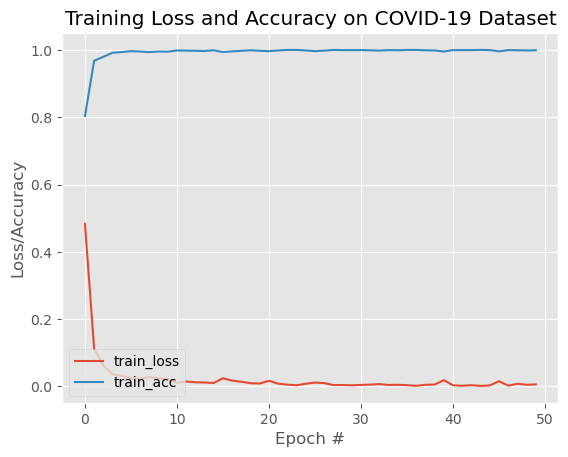

In [15]:
print('confusion matrix:')
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)

# serialize the model to disk
print('Saving COVID-19 detector model on {model_name} data...')
model.save(os.path.join(MODEL_DIR, model_name), save_format='h5')

# plot the training loss and accuracy
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['accuracy'], label='train_acc')
plt.title('Training Loss and Accuracy on COVID-19 Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig(os.path.join(MODEL_DIR, plot_path))

print('Done, shuttting down!')
